[Dépôt Git](https://github.com/JeanRosselVallee/project_8.git)

[Application Web](http://localhost:8501/)

# Initialisation

In [63]:
# pip install --quiet streamlit plotly mlflow xgboost

In [64]:
# pip install --quiet -r ./data/model/requirements.txt

In [6]:
import streamlit as st
import pandas as pd
import numpy as np
import json
import mlflow

In [14]:
dir_in = './data/in/'

# App Web

## Page d'accueil

In [67]:
path_code = 'Index.py'

In [68]:
ls $path_code

Index.py


In [69]:
cat $path_code

'''
Index.py
Main page of Streamlit app
'''

import streamlit as st

st.set_page_config(
	page_title="Hello",
	page_icon="👋",
	layout="wide"	
)

# Customize the sidebar
st.sidebar.title("About")
st.sidebar.info("""
	Web App URL: <https://project8-ocr.streamlit.app/>
	GitHub Repository: <https://github.com/JeanRosselVallee/project_8>
	""")
st.sidebar.image("https://www.whenthebanksaysno.co.uk/wp-content/uploads/2023/05/D9585792-ED4C-4363-900E-1EDCE31B99B1.jpeg")

# Customize page title
st.title("Credit Application Dashboard")

st.markdown(
    """
    This multipage app template demonstrates various interactive web apps created using [streamlit](https://streamlit.io) and [leafmap](https://leafmap.org). It is an open-source project and you are very welcome to contribute to the [GitHub repository](https://github.com/giswqs/streamlit-multipage-template).
    """
)

st.header("Instructions")

markdown = """
1. Select a client's application for credit
2. Find your favorite emoji from https:/

## Serveur local

In [70]:
#! streamlit run $path_code

# Jeu de données

Les prédictions se feront sur le jeu de test parce que le modèle a été entraîné sur celui d'entraînement

In [71]:
ls ../project_7/modeling/data/out/*test_2.csv ../project_7/modeling/data/out/*pred*.csv

../project_7/modeling/data/out/X_test_2.csv
../project_7/modeling/data/out/y_pred_4.csv
../project_7/modeling/data/out/y_test_2.csv


In [72]:
cp ../project_7/modeling/data/out/*_test_2.csv ./data/in/

In [73]:
cp ../project_7/test_api/data/li_features.txt ./data/in/

In [74]:
ls ./data/in/

config.json      model_optimal_simplified.json  X_TP.csv
data.csv         X_test_2.csv                   y_pred_4.csv
li_features.txt  X_TN.csv                       y_test_2.csv


In [75]:
! for file_i in ./data/in/* ; do wc -l $file_i ; done

8 ./data/in/config.json
48679 ./data/in/data.csv
1 ./data/in/li_features.txt
0 ./data/in/model_optimal_simplified.json
48679 ./data/in/X_test_2.csv
33121 ./data/in/X_TN.csv
2359 ./data/in/X_TP.csv
48679 ./data/in/y_pred_4.csv
48679 ./data/in/y_test_2.csv


### Chargement

In [19]:
def load_data(file):
    df_contents = pd.read_csv(file)   .rename(columns={'Unnamed: 0': 'request_id'}) \
                                      .set_index('request_id')
    return df_contents

#### Attributs

In [20]:
path_X = dir_in + 'X_test_2.csv'
df_X = load_data(path_X)
df_X.shape

(48678, 125)

In [21]:
with open(dir_in + 'li_features.txt') as file_object:
    str_li_features = file_object.read()
li_features = eval(str_li_features)
li_features

['CODE_GENDER_M',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'NAME_EDUCATION_TYPE_Secondary_or_secondary_special',
 'NAME_EDUCATION_TYPE_Higher_education',
 'NAME_CONTRACT_TYPE_Cash_loans',
 'NAME_INCOME_TYPE_Working']

In [22]:
df_X = df_X[li_features]
display(df_X.head(1))
df_X.shape

,CODE_GENDER_M,EXT_SOURCE_3,EXT_SOURCE_2,NAME_EDUCATION_TYPE_Secondary_or_secondary_special,NAME_EDUCATION_TYPE_Higher_education,NAME_CONTRACT_TYPE_Cash_loans,NAME_INCOME_TYPE_Working
request_id,,,,,,,
155094,0,0.770087,0.607697,0,1,1,0


(48678, 7)

#### Cible

In [23]:
path_y = dir_in + 'y_test_2.csv'
df_y = load_data(path_y)
df_y.shape
display(df_y.head(1))

,TARGET
request_id,
155094,0


### Jointure d'attributs et cible

In [24]:
df_data = df_X.join(df_y)
#df_data.columns = li_variables_simplified

In [25]:
display(df_data.head(1))
df_data.shape

,CODE_GENDER_M,EXT_SOURCE_3,EXT_SOURCE_2,NAME_EDUCATION_TYPE_Secondary_or_secondary_special,NAME_EDUCATION_TYPE_Higher_education,NAME_CONTRACT_TYPE_Cash_loans,NAME_INCOME_TYPE_Working,TARGET
request_id,,,,,,,,
155094,0,0.770087,0.607697,0,1,1,0,0


(48678, 8)

### Sauvegarde

In [82]:
df_data.to_csv(dir_in + 'data.csv')

In [83]:
ls $dir_in/data.csv

./data/in//data.csv


In [88]:
! head -n 3 $dir_in/data.csv

request_id,CODE_GENDER_M,EXT_SOURCE_3,EXT_SOURCE_2,NAME_EDUCATION_TYPE_Secondary_or_secondary_special,NAME_EDUCATION_TYPE_Higher_education,NAME_CONTRACT_TYPE_Cash_loans,NAME_INCOME_TYPE_Working,TARGET
155094,0,0.7700870700124128,0.6076973714617412,0,1,1,0,0
74108,0,0.4258928980051529,0.7318427244611323,1,0,1,1,0


# Score normalisé

L'affichage sur la jauge a besoin d'un score normalisé par rapport au seuil entre les 2 classes:
|score original|score normalisé|
|--|--|
|0|0|
|seuil S|0.5|
|1|1|

On obtient ces résultats en élévant le score à la puissance P

$$ T ^ P = 0.50 \quad \quad \quad \text{where T : threshold} $$
$$ \Rightarrow \quad P = \frac{\log_{2}(0.50)}{\log_{2}(threshold)} = -\frac{1}{\log_{2}(threshold)} $$


In [7]:
def get_normalizing_power(threshold) :
	normalizing_power = - 1 / np.log2(threshold)
	return normalizing_power

# Modèle adapté

In [8]:
from xgboost import XGBClassifier

## Classe du modèle

- Pour le projet précédent, on affichait la la probabilité qu'un emprunteur appartienne à la classe "1"
- Pour ce projet avec un tableau de bord destiné aux utilisateurs finaux, il est plus pertinent d'afficher la probabilité de la classe "0"

In [9]:
class XGB_prob(XGBClassifier):
    threshold = 0 
    def __init__(self, threshold=0.5, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
    def fit(self, df_X_train, df_y_train, **kwargs) : 
        super().fit(df_X_train, df_y_train, **kwargs)
    def predict(self, df_X_subset, bool_save_events=True):      
        np_y_pred_proba = super().predict_proba(df_X_subset)[:, 1]  # class 1 probas  
        np_y_normalized = np.power(np_y_pred_proba, get_normalizing_power(self.threshold))
        proba_class_0   = 1 - np_y_normalized
        return proba_class_0

## Récupération

On importe le modèle de prédiction le plus récent: celui deployé en pré-Prod car celui en Prod est absent du dépôt Git

In [10]:
path_config = '../config.json' 

In [11]:
# cp ../project_7/config.json ./data/in/

In [12]:
# cp ../project_7/modeling/data/out/model_optimal_simplified.json ./data/in/

In [15]:
model_prob = XGB_prob()
model_prob.load_model(dir_in + 'model_optimal_simplified.json')
model_prob

XGB_prob(base_score='1.572525E-1', booster='gbtree', callbacks=None,
         colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
         device=None, early_stopping_rounds=None, enable_categorical=False,
         eval_metric=None,
         feature_types=['int', 'float', 'float', 'int', 'int', 'int', 'int'],
         gamma=None, grow_policy=None, importance_type=None,
         interaction_constraints=None, learning_rate=None, max_bin=None,
         max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
         max_depth=None, max_leaves=None, min_child_weight=None, missing=nan,
         monotone_constraints=None, multi_strategy=None, n_estimators=None,
         n_jobs=None, num_parallel_tree=None, objective='binary:logistic', ...)

### Génération de signature

In [34]:
from mlflow.models.signature import infer_signature

In [35]:
model_signature = infer_signature(df_X.head(1), df_y.head(1))

/home/user_n/anaconda3/envs/env_proj_8/lib/python3.10/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


#### Attributs

In [36]:
list(model_signature.inputs)[:10]

['CODE_GENDER_M': long (required),
 'EXT_SOURCE_3': double (required),
 'EXT_SOURCE_2': double (required),
 'NAME_EDUCATION_TYPE_Secondary_or_secondary_special': long (required),
 'NAME_EDUCATION_TYPE_Higher_education': long (required),
 'NAME_CONTRACT_TYPE_Cash_loans': long (required),
 'NAME_INCOME_TYPE_Working': long (required)]

#### Cible

In [37]:
list(model_signature.outputs)

['TARGET': long (required)]

### Mise à jour du seuil binaire

In [38]:
dict_params_old = model_prob.get_params()
dict_params_old['threshold']

0.5

In [39]:
with open(dir_in + 'config.json', 'r') as json_file: dict_to_config = json.load(json_file)
best_threshold = float(dict_to_config['best_threshold'])

In [40]:
setattr(model_prob, 'threshold', best_threshold)

In [41]:
dict_params_new = model_prob.get_params()
dict_params_new['threshold']

0.09

## Déploiement

In [42]:
from mlflow import sklearn as skl

In [43]:
model_path = './data/model/'
! rm -rf $model_path ; mkdir -p "$model_path"
%time skl.save_model(model_prob, model_path, signature=model_signature)

CPU times: user 1.13 s, sys: 67.3 ms, total: 1.2 s
Wall time: 3.56 s


#### Fichiers générés

In [44]:
!find "$model_path"

./data/model/
./data/model/conda.yaml
./data/model/python_env.yaml
./data/model/MLmodel
./data/model/model.pkl
./data/model/requirements.txt


# Mise en service

## Arrêt

In [45]:
port_server = '5677'

In [46]:
mask = ':' + port_server
! pkill -f "$mask"

## Démarrage

In [47]:
ip_host = '0.0.0.0'
shell_command =  'nohup mlflow models serve -m '
shell_command += model_path + ' -p ' + port_server + ' -h ' + ip_host #+ ' --env-manager=conda'
print(shell_command)
get_ipython().system_raw(shell_command + ' --no-conda &')          # runs model API in background

nohup mlflow models serve -m ./data/model/ -p 5677 -h 0.0.0.0


2024/07/09 11:04:05 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2024/07/09 11:04:05 INFO mlflow.pyfunc.backend: === Running command 'exec gunicorn --timeout=60 -b 0.0.0.0:5677 -w 1 ${GUNICORN_CMD_ARGS} -- mlflow.pyfunc.scoring_server.wsgi:app'
[2024-07-09 11:04:05 +0200] [83204] [INFO] Starting gunicorn 22.0.0
[2024-07-09 11:04:05 +0200] [83204] [INFO] Listening at: http://0.0.0.0:5677 (83204)
[2024-07-09 11:04:05 +0200] [83204] [INFO] Using worker: sync
[2024-07-09 11:04:05 +0200] [83205] [INFO] Booting worker with pid: 83205


## Vérification d'exécution

Il y a 2 processus qui tournent par serveur

In [48]:
! ps aux | grep "scoring_server" | grep -v "grep" | awk '{print $2, $15, $19}'

83204 0.0.0.0:5677 mlflow.pyfunc.scoring_server.wsgi:app
83205 0.0.0.0:5677 mlflow.pyfunc.scoring_server.wsgi:app


# Tests

In [275]:
url_api = 'localhost:' + port_server + '/invocations'
print('URL API    -> http://' + url_api)

URL API    -> http://localhost:5677/invocations


## Prédictions

Demande par requête POST de prédiction de la cible pour une observation

In [188]:
#cp ../project_7/modeling/data/out/X_T[PN].csv ./data/in/

In [189]:
nb_observations = 1

### Cas TP

In [248]:
path_TP = dir_in + 'X_TP.csv'
df_TP = pd.read_csv(path_TP)

In [276]:
df_TP_sample = df_TP.sample(nb_observations)
df_TP_sample

,CODE_GENDER_M,EXT_SOURCE_3,EXT_SOURCE_2,NAME_EDUCATION_TYPE_Secondary_or_secondary_special,NAME_EDUCATION_TYPE_Higher_education,NAME_CONTRACT_TYPE_Cash_loans,NAME_INCOME_TYPE_Working
278,1,0.403142,0.036837,1,0,1,1


In [277]:
def get_curl_command(df_sample, url) :
    str_features_values = df_sample.to_json(orient='split')
    str_data = '\'{"dataframe_split": ' + str_features_values + '}\' '
    return 'curl -d' + str_data + '''-H 'Content-Type: application/json' -X POST ''' + url

Vérifier que cette ligne de commande Linux renvoie une prédiction de classe "1"

In [278]:
shell_command = get_curl_command(df_TP_sample, url_api)
print(shell_command)

curl -d'{"dataframe_split": {"columns":["CODE_GENDER_M","EXT_SOURCE_3","EXT_SOURCE_2","NAME_EDUCATION_TYPE_Secondary_or_secondary_special","NAME_EDUCATION_TYPE_Higher_education","NAME_CONTRACT_TYPE_Cash_loans","NAME_INCOME_TYPE_Working"],"index":[278],"data":[[1,0.4031416767,0.0368366718,1,0,1,1]]}}' -H 'Content-Type: application/json' -X POST localhost:5677/invocations


In [279]:
get_ipython().system_raw(shell_command)  

{"predictions": [0.2895166873931885]}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   329  100    37  100   292   1480  11680 --:--:-- --:--:-- --:--:-- 13160


### Cas TN

In [221]:
path_TN = dir_in + 'X_TN.csv'
df_TN = pd.read_csv(path_TN)

In [280]:
df_TN_sample = df_TN.sample(nb_observations)
df_TN_sample

,CODE_GENDER_M,EXT_SOURCE_3,EXT_SOURCE_2,NAME_EDUCATION_TYPE_Secondary_or_secondary_special,NAME_EDUCATION_TYPE_Higher_education,NAME_CONTRACT_TYPE_Cash_loans,NAME_INCOME_TYPE_Working
25354,1,0.656158,0.602456,0,1,1,1


Vérifier que cette ligne de commande Linux renvoie une prédiction de classe "0"

In [281]:
shell_command = get_curl_command(df_TN_sample, url_api)
print(shell_command)

curl -d'{"dataframe_split": {"columns":["CODE_GENDER_M","EXT_SOURCE_3","EXT_SOURCE_2","NAME_EDUCATION_TYPE_Secondary_or_secondary_special","NAME_EDUCATION_TYPE_Higher_education","NAME_CONTRACT_TYPE_Cash_loans","NAME_INCOME_TYPE_Working"],"index":[25354],"data":[[1,0.656158373,0.6024563021,0,1,1,1]]}}' -H 'Content-Type: application/json' -X POST localhost:5677/invocations


In [282]:
get_ipython().system_raw(shell_command)  

{"predictions": [0.6152771711349487]}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   330  100    37  100   293   1761  13952 --:--:-- --:--:-- --:--:-- 15714


# Feature Importance

#### Entraînement

In [10]:
# model_prob.fit(df_X_train_simplified, df_y_train)

/home/user_n/anaconda3/envs/env_proj_7/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:50:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "threshold" } are not used.

  warnings.warn(smsg, UserWarning)


## Importance Globale

- appliqué au jeu de test

In [284]:
pip install --quiet shap

Note: you may need to restart the kernel to use updated packages.


In [295]:
pip install --quiet PyQt6

Note: you may need to restart the kernel to use updated packages.


In [1]:
import shap
#import matplotlib.pyplot as plt 

/home/user_n/anaconda3/envs/env_proj_8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
explainer = shap.TreeExplainer(model_prob)
shap_values = explainer.shap_values(df_X)

**Guide d'analyse des "violons"**
- Les attributs sont triés par ordre d'importance décroissante
- Pour chaque attribut, on indique :
    - la grandeur des valeurs 
        - faibles en bleu
        - importantes en rouge
    - leur distribution par la hauteur des traits
    - leur effet sur le score (axe X)
        - négatif
        - positif

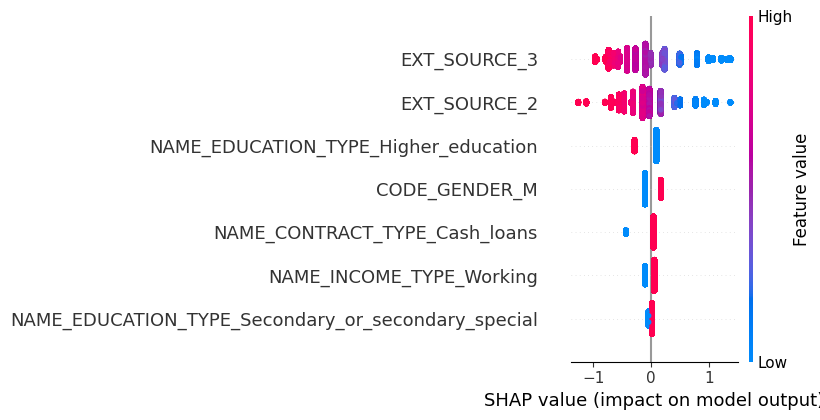

In [27]:
shap.summary_plot(shap_values, df_X)

**Interprétation**
1. Effets
    - Pour obtenir un meilleur score pour obtenir un prêt, il faudrait :
        - des valeurs faibles de scores fournis par des sources externes 
        - pas d'éducation supérieure
        - être un homme
        - demander un retrait du prêt en espèces
        - être salarié
        - avoir une éducation secondaire
2. Distribution 
    - Observations majoritaires :        
        - des valeurs fortes de scores fournis par des sources externes 
        - pas d'éducation supérieure
        - des femmes
        - demandes de retrait du prêt en espèces
        - être salarié
        - éducation secondaire

## Importance Locale

### Graphe en cascade d'un échantillon

**Interprétation**

Pour interpréter ce graphe, on se déplace du bas vers le haut :
- on démarre en bas du diagramme avec la valeur de base en gris 
- cette valeur est corrigée progresivement par les valeurs _SHAP_ de chaque attribut
- les flèches rouges ont un impact positif et les bleues négatif
- jusqu'à atteindre la valeur cible en gris en haut du diagramme

Expected class= 0


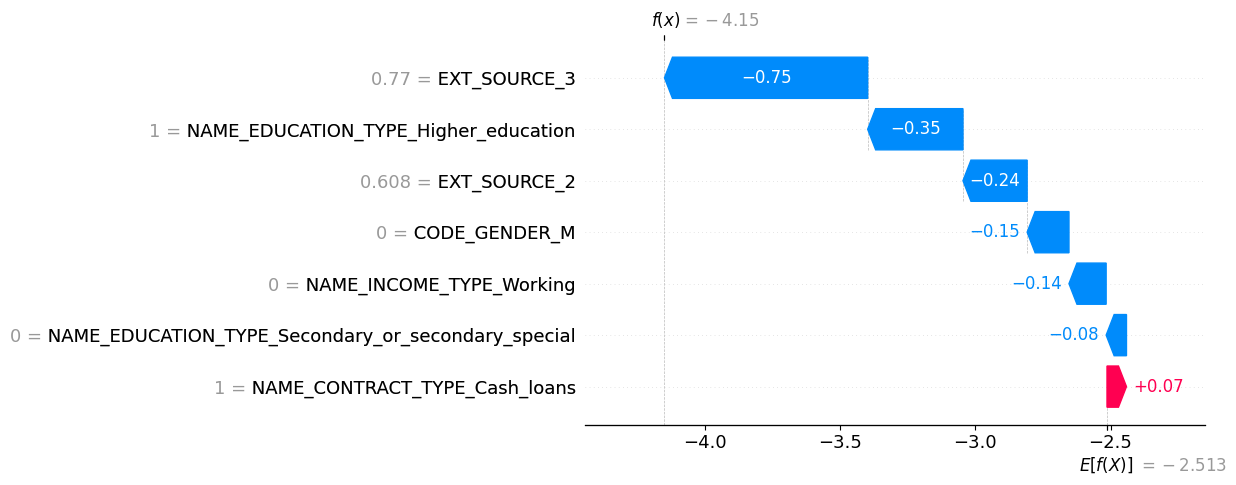

Expected class= 0


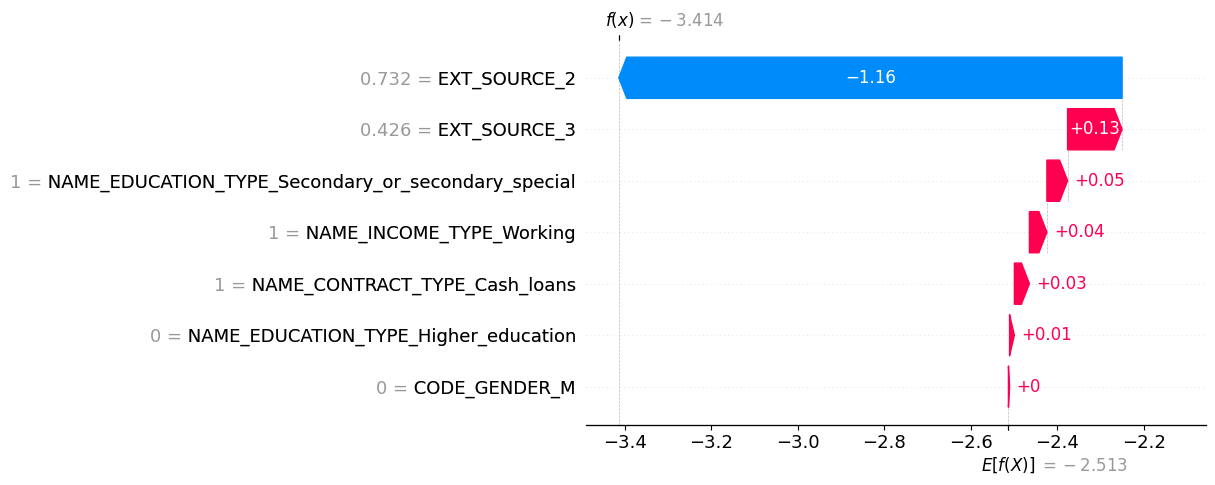

Expected class= 0


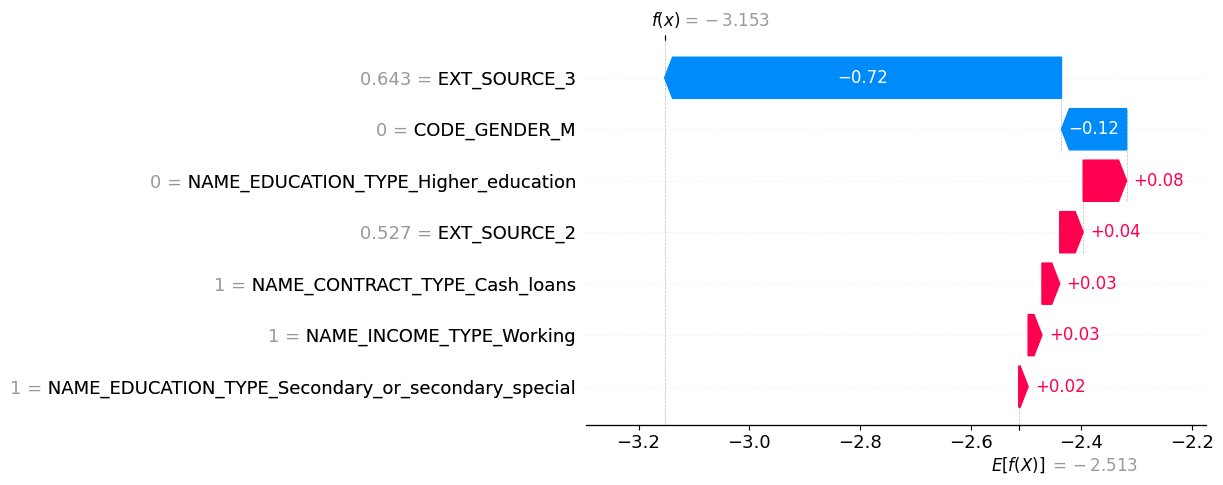

Expected class= 1


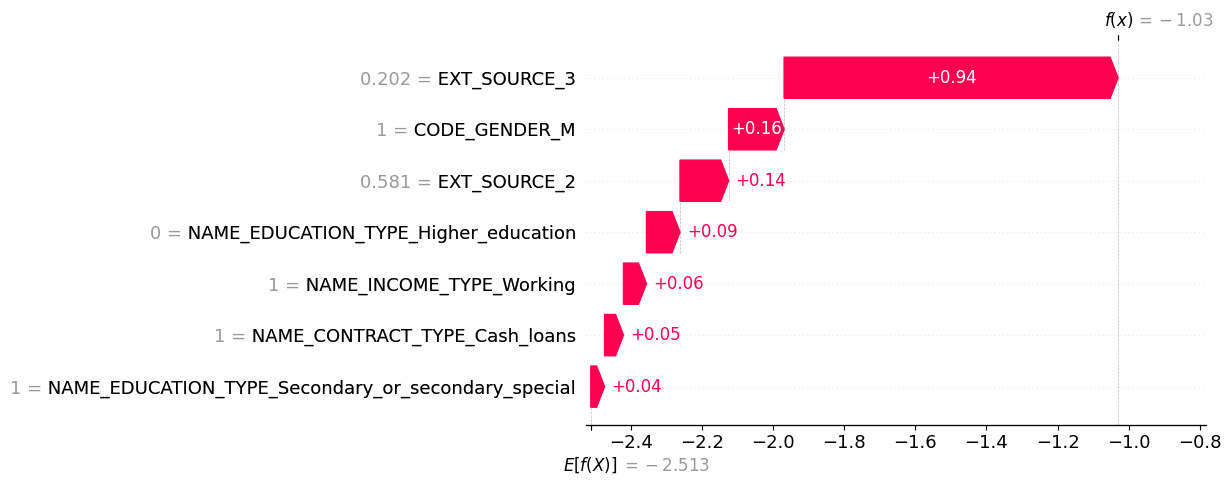

Expected class= 0


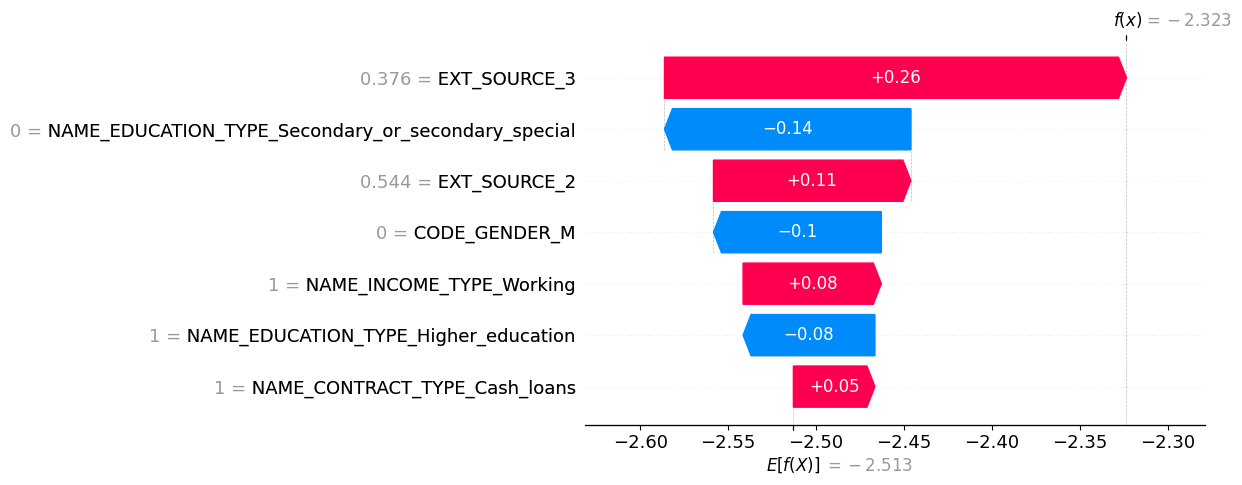

Expected class= 0


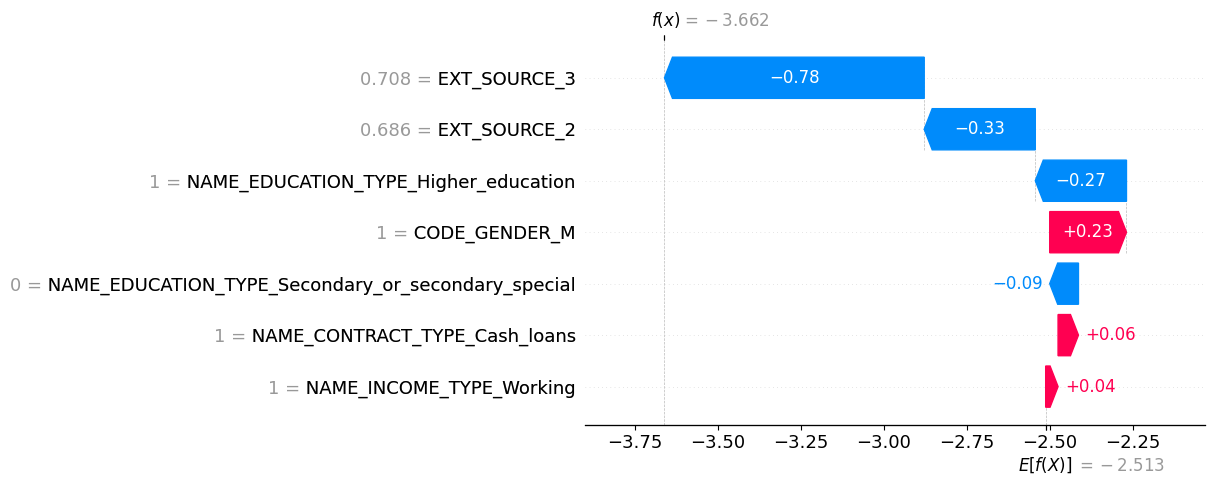

Expected class= 1


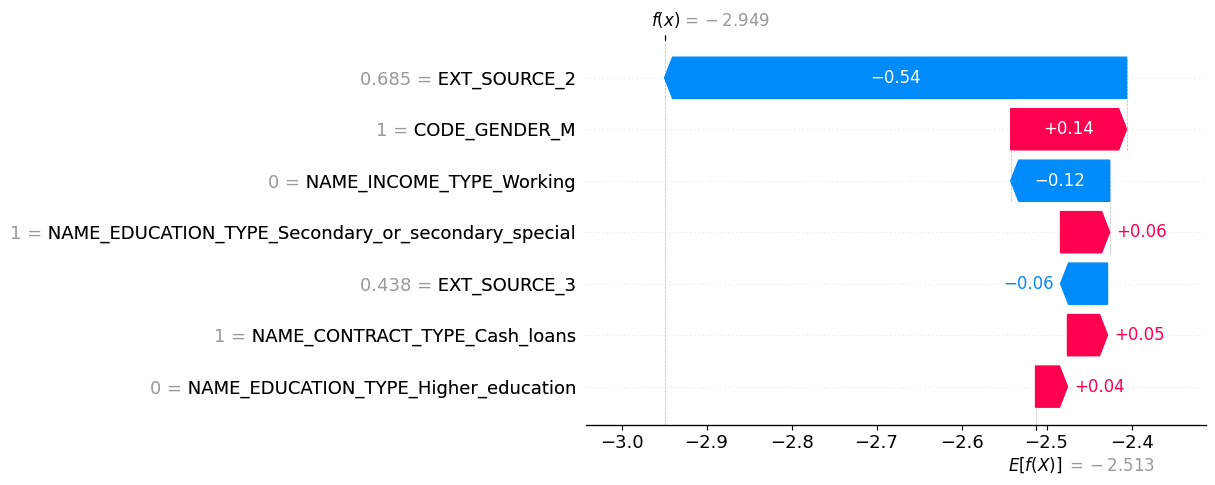

Expected class= 0


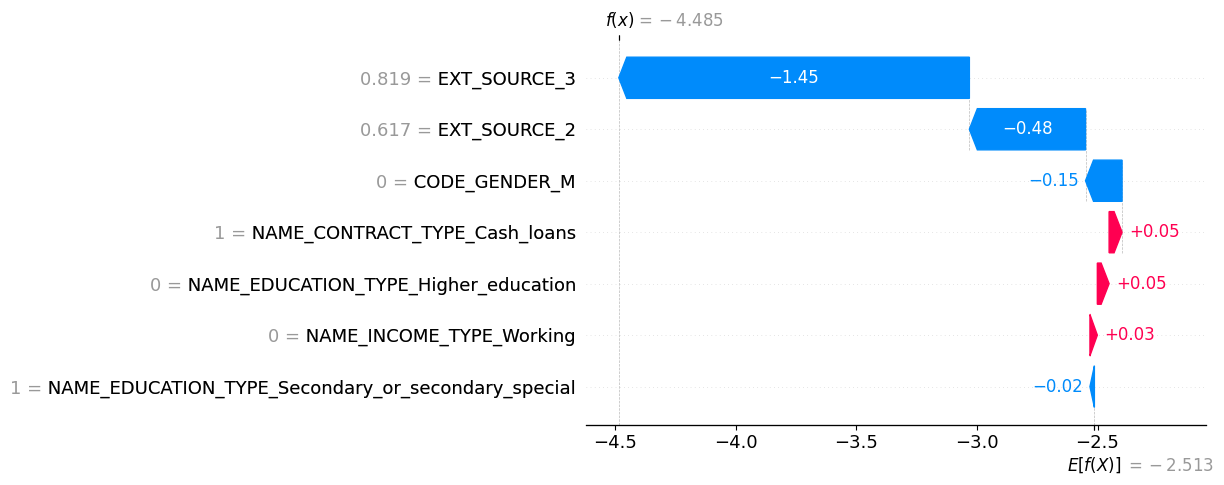

Expected class= 0


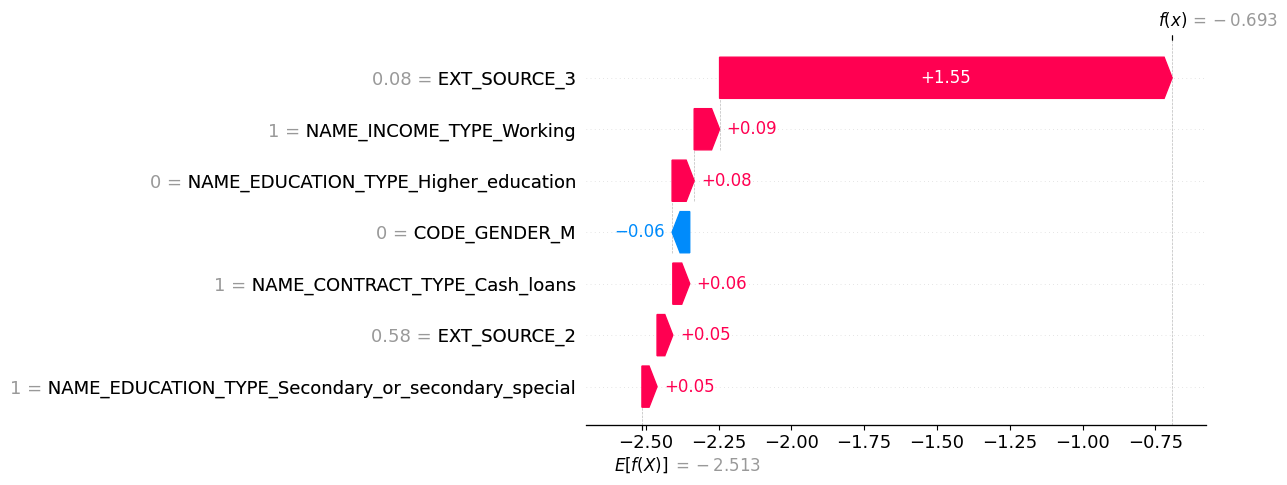

Expected class= 0


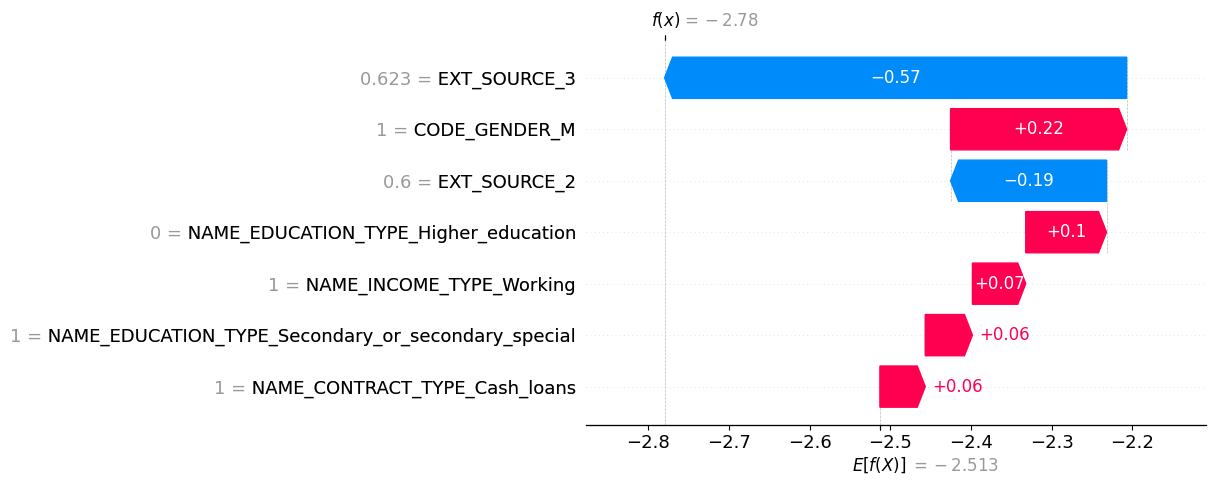

In [24]:
for idx in range(10) :
    print('Expected class=', df_y_test.iloc[idx].values[0])
    shap.plots.waterfall(explainer(df_X_test_simplified)[idx], max_display=7)

# Fin du traitement

In [225]:
assert(False) # prevents the execution of following cells

AssertionError: 

# Annexes